## Imports

In [123]:
import pathlib
import PIL.Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import splitfolders, os, glob, shutil

import mlflow.tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [124]:
mlflow.tensorflow.autolog()

## Read Image Data

In [125]:
#Set data directory
data_dir = pathlib.Path('data-no-trash')

In [126]:
#show number of images included in directory
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2526


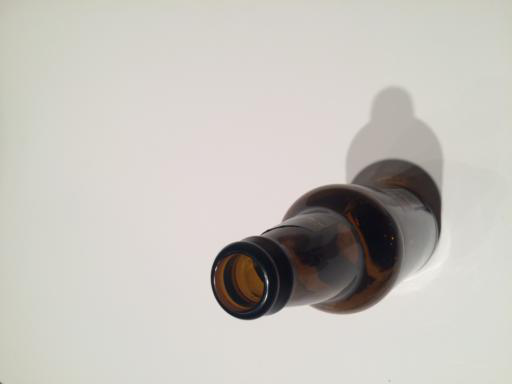

In [127]:
#Display a sample glass image
glass = list(data_dir.glob('glass/*'))
PIL.Image.open(str(glass[0]))

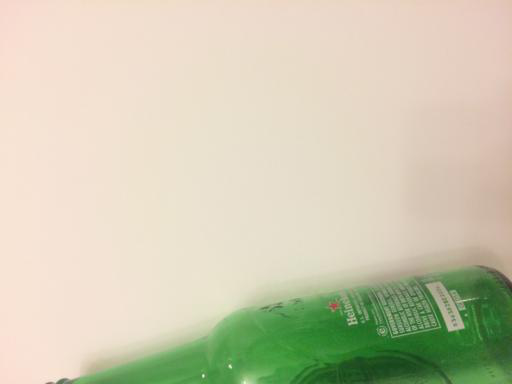

In [128]:
#Display another sample glass image
PIL.Image.open(str(glass[1]))

## Load Dataset

In [129]:
#Define some parameters for the loader:
batch_size = 32
img_height = 384
img_width = 512

#TODO: Resize to smaller size

In [130]:
# #clear images folder
folder = './images'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [131]:
def train_test_split_folders(data_dir):
    splitfolders.ratio(data_dir, output="images", seed=1337, ratio=(.8, 0.1,0.1))
    image_dir = 'images'

    #create training split  
    train_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/train',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    val_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/val',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    test_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/test',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = train_test_split_folders(data_dir=data_dir)

Found 2030 files belonging to 6 classes.
Found 252 files belonging to 6 classes.
Found 258 files belonging to 6 classes.


In [132]:
#Show names of the found classes
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'other', 'paper', 'plastic']


## Configure the dataset

*Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:*

    - Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
    
    - Dataset.prefetch overlaps data preprocessing and model execution while training.

*Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.*

### Preprocess the data

In [133]:
# create normalization layer
normalizing_layer = tf.keras.Sequential([
    # layers.Resizing(512, 384),
    layers.Rescaling(1./255),
])

In [134]:
# create preporcessing layer to agument data
preprocessing_layer = tf.keras.Sequential([
    # normalizing_layer,
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(0.1),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(width_factor=0.1, height_factor=0.1),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2)
    
])

In [135]:
# preprocess training data
# normalized_train_ds = train_ds.map(lambda x, y: (preprocessing_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_train_ds))
# first_image = image_batch[0]

# nomralize vlaidation data
# normalized_val_ds = val_ds.map(lambda x, y: (normalizing_layer(x), y))

# Notice the pixel values are now in '[0, 1]'
# print(np.min(first_image), np.max(first_image))

In [136]:
AUTOTUNE = tf.data.AUTOTUNE

#load data into cache to reduce i/o
# train_ds = normalized_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Configure the Model

In [137]:
# num_classes = len(class_names)

# model = tf.keras.Sequential(
#     [
#     tf.keras.layers.Rescaling(1./255),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPool2D(),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPool2D(),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPool2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(num_classes)
#     ]
# )

In [138]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.1),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [139]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Train the Model

In [140]:
history = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=10
)

2023/01/06 13:45:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4fa76c9c2edb4ba69103a4386904be7b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/01/06 13:45:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Felix\anaconda3\envs\tfdml_plugin\lib\site-packages\mlflow\tensorflow\_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Epoch 1/10
64/64 [==============================] - 11s 130ms/step - loss: 1.5096 - accuracy: 0.3384 - val_loss: 1.2689 - val_accuracy: 0.4524
Epoch 2/10
64/64 [==============================] - 8s 125ms/step - loss: 1.2909 - accuracy: 0.4754 - val_loss: 1.2634 - val_accuracy: 0.4683
Epoch 3/10
64/64 [==============================] - 8s 125ms/step - loss: 1.1117 - accuracy: 0.5586 - val_loss: 1.1480 - val_accuracy: 0.5357
Epoch 4/10
64/64 [==============================] - 8s 124ms/step - loss: 0.9716 - accuracy: 0.6099 - val_loss: 1.1313 - val_accuracy: 0.5794
Epoch 5/10
64/64 [==============================] - 8s 124ms/step - loss: 0.8055 - accuracy: 0.6956 - val_loss: 1.2042 - val_accuracy: 0.5754
Epoch 6/10
64/64 [==============================] - 8s 124ms/step - loss: 0.6460 - accuracy: 0.7557 - val_loss: 1.1922 - val_accuracy: 0.5992
Epoch 7/10
64/64 [==============================] - 8s 124ms/step - loss: 0.4808 - accuracy: 0.8276 - val_loss: 1.1810 - val_accuracy: 0.6429
Epoch

INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmpe8hqz7xd\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmpe8hqz7xd\model\data\model\assets
2023/01/06 13:46:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Felix\anaconda3\envs\tfdml_plugin\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


### Save Training History

In [141]:
#export training history
save = False

if save:
    np.save('./trainHistoryDict/Net2_30_history.npy',history.history)

In [142]:
history = history.history

In [143]:
#import training history
load = False

if load:
    history=np.load('my_history.npy', allow_pickle='TRUE').item()

### Visualize Results

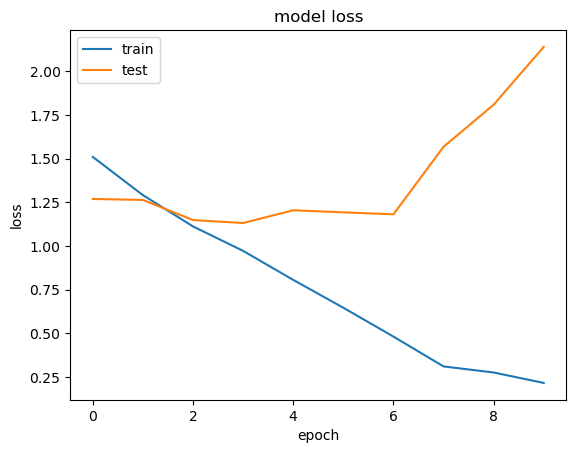

In [144]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

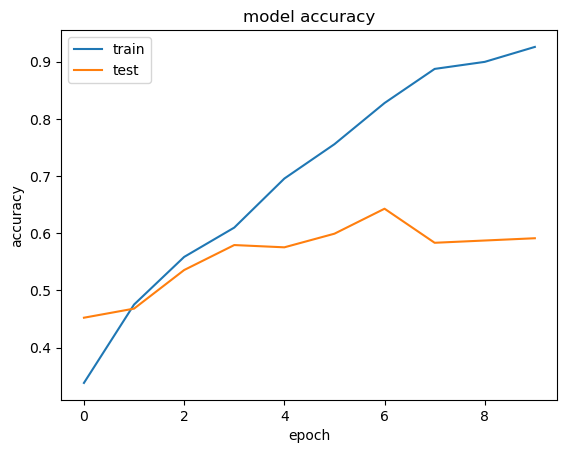

In [145]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [146]:
# def plot_image(i, predictions_array, true_label, img):
#   true_label, img = true_label[i], img[i]
#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])

#   plt.imshow(img, cmap=plt.cm.binary)

#   predicted_label = np.argmax(predictions_array)
#   if predicted_label == true_label:
#     color = 'blue'
#   else:
#     color = 'red'

#   plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
#                                 100*np.max(predictions_array),
#                                 class_names[true_label]),
#                                 color=color)

# def plot_value_array(i, predictions_array, true_label):
#   true_label = true_label[i]
#   plt.grid(False)
#   plt.xticks(range(10))
#   plt.yticks([])
#   thisplot = plt.bar(range(10), predictions_array, color="#777777")
#   plt.ylim([0, 1])
#   predicted_label = np.argmax(predictions_array)

#   thisplot[predicted_label].set_color('red')
#   thisplot[true_label].set_color('blue')

In [147]:
# i = 0
# plt.figure(figsize=(6,3))
# plt.subplot(1,2,1)
# plot_image(i, predictions[i], test_labels, test_images)
# plt.subplot(1,2,2)
# plot_value_array(i, predictions[i],  test_labels)
# plt.show()

In [148]:
# TODO: Tensorboard
# TODO: Predict Sample image
# TODO: Model Optimizer implementieren (KERAS Tuner)